In [60]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
from copy import copy
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import math
import cmocean

In [61]:
datadir = '/Users/rfische1/Documents/UU/'#'/data/oceanparcels/output_data/data_Delphine/' #'/nethome/lobel001/biofouling_3dtransport_2/Simulation/Sim_output/' #/data/oceanparcels/output_data/data_Reint/' #

In [62]:
regions = {'EqPac': 'Equatorial Pacific',
           'GPGP': 'Great Pacific Garbage Patch',
           'SO': 'Southern Ocean',
           'NPSG': 'North Pacific Subtropical Gyre'}
adv = {'bfnoadv': 'No Advection','bfadv': 'Advection'}
r_pl_clist = ['#7a0177','#c51b8a','#f768a1', '#fbb4b9']
r_pl_cmap = plt.get_cmap('RdPu_r')

In [63]:
runtime = 458 #822        # [days]
start_yr = 2003
biofouling = 'MEDUSA'
rho_bf = 1170 #
rho_pl = 920

## Original

In [122]:
region = ['EqPac','NPSG', 'SO']
dt = 60                       # [seconds]
outputdt = 12                 # [hours]
mixing = 'markov_0_'+biofouling
time_plot = round((runtime-91)*24/outputdt)
sizebinedges = [1e-3, 1e-4, 1e-5]
res ='1x1'
proc = 'bfadv'
season = 'Oct'
season_string = {'Jan':'January - July', 'MAM':'March - September', 'JJA':'June - December', 'SON':'September - March','DJF':'December - June'}

In [123]:
ds_0 = xr.open_dataset(datadir+'regional_'+region[0]+'_'+proc+'_'+season+'_'+str(start_yr)+'_'+res+'res_'+mixing+'_'+str(rho_bf)+'rhobf_'+str(rho_pl)+'rhopl_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc')
ds_1 = xr.open_dataset(datadir+'regional_'+region[1]+'_'+proc+'_'+season+'_'+str(start_yr)+'_'+res+'res_'+mixing+'_'+str(rho_bf)+'rhobf_'+str(rho_pl)+'rhopl_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc')
ds_2 = xr.open_dataset(datadir+'regional_'+region[2]+'_'+proc+'_'+season+'_'+str(start_yr)+'_'+res+'res_'+mixing+'_'+str(rho_bf)+'rhobf_'+str(rho_pl)+'rhopl_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc')

In [124]:
dslist = [ds_0, ds_1, ds_2]

In [125]:
mld_0 = np.mean(ds_0['mld'][:,1:],axis=0)
ez_0 = np.mean(ds_0['euphz'][:,1:],axis=0)
mld_0 = np.concatenate(([mld_0[0]],mld_0))
ez_0 = np.concatenate(([ez_0[0]],ez_0))

mld_1 = np.mean(ds_1['mld'][:,1:],axis=0)
ez_1 = np.mean(ds_1['euphz'][:,1:],axis=0)
mld_1 = np.concatenate(([mld_1[0]],mld_1))
ez_1 = np.concatenate(([ez_1[0]],ez_1))

mld_2 = np.mean(ds_2['mld'][:,1:],axis=0)
ez_2 = np.mean(ds_2['euphz'][:,1:],axis=0)
mld_2 = np.concatenate(([mld_2[0]],mld_2))
ez_2 = np.concatenate(([ez_2[0]],ez_2))

mldlist = [mld_0, mld_1, mld_2]
ezlist = [ez_0, ez_1, ez_2]

In [126]:
obs_ids=[0,379]  # one year

In [127]:
split_ds_0 = list(ds_0.groupby_bins('r_pl',sizebinedges[::-1]))[::-1]
split_ds_1 = list(ds_1.groupby_bins('r_pl',sizebinedges[::-1]))[::-1]
split_ds_2 = list(ds_2.groupby_bins('r_pl',sizebinedges[::-1]))[::-1]
split_dslist = [split_ds_0, split_ds_1,split_ds_2]

## Figure 2

In [128]:
depthbins = np.concatenate((np.linspace(0,445,90), np.linspace(450,5500,102)))
sub_depths = [[0,91],[90,len(depthbins)]]
starttimes=(ds_0['time'][0,obs_ids[0]:obs_ids[1]]-np.timedelta64(int(outputdt/2.), 'h')).values
endtime = (ds_0['time'][0,obs_ids[1]]+np.timedelta64(int(outputdt/2.), 'h')).values
timebins = np.append(starttimes,endtime)
daybins =(timebins-timebins[0]).astype(np.float64)*(np.timedelta64(1,'ns') / np.timedelta64(1,'D'))
timeperiod = obs_ids[1]-obs_ids[0]

### Create and save distibution data

In [129]:
depth_densities = np.zeros((len(dslist),len(split_ds_2),timeperiod,len(depthbins)-1))
depth_numbers = np.zeros((len(dslist),len(split_ds_2),timeperiod,len(depthbins)-1))

for k in range(len(dslist)):
    split_ds = split_dslist[k]
    for i in range(len(depth_densities[0])):
        for j in range(timeperiod):
            values, bins = np.histogram(split_ds[i][1]['z'].isel(obs=obs_ids[0]+j), depthbins)
            depth_numbers[k,i,j] = values/np.diff(depthbins)

In [130]:
# np.save(datadir+'depth_numbers_'+str(rho_bf)+'rhobf_'+str(rho_pl)+'rhopl_'+str(runtime)+'ds.npy', depth_numbers)

### Plot

In [131]:
depth_cmap = copy(plt.get_cmap('magma'))
# depth_cmap.set_over('w')

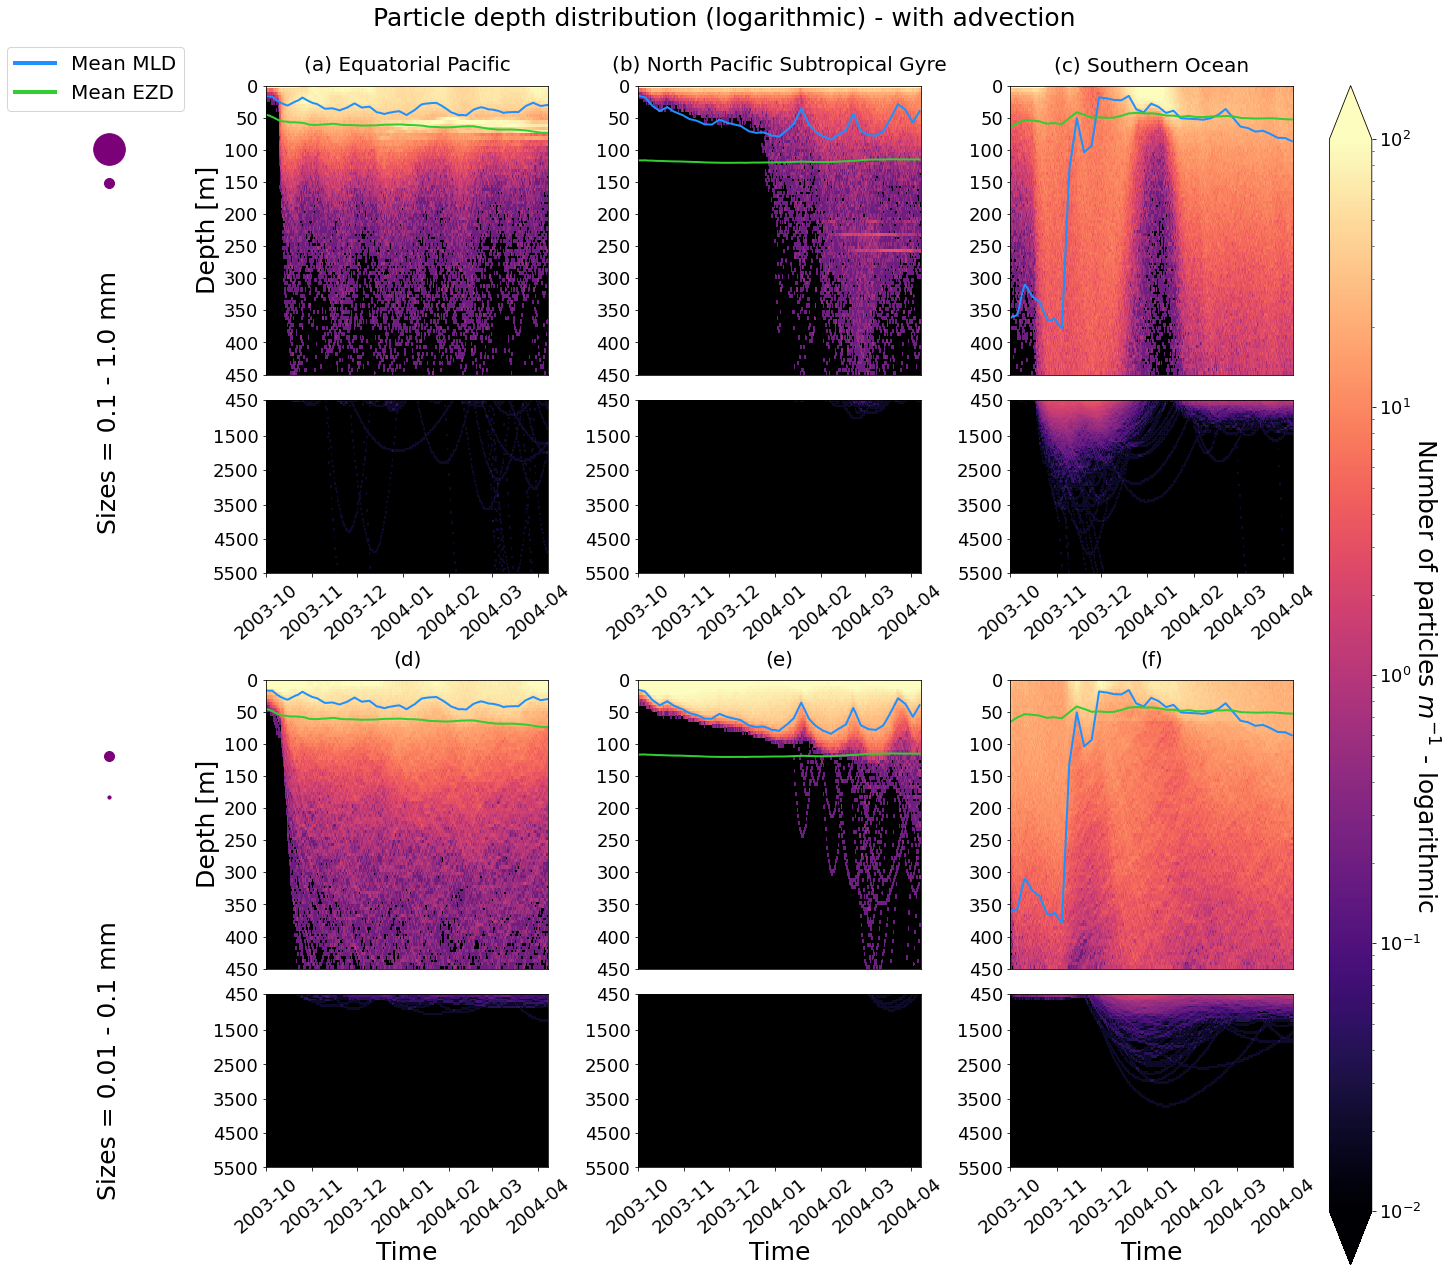

In [132]:
fig = plt.figure(figsize=(20,17),constrained_layout=True)
gs = gridspec.GridSpec(ncols=5, nrows=17, width_ratios=[0.3,1,1,1,0.15], figure=fig)
ax1 = fig.add_subplot(gs[:8, 0])
ax2 = fig.add_subplot(gs[8:, 0])

ax3 = fig.add_subplot(gs[:5, 1])
ax4 = fig.add_subplot(gs[5:8, 1]) 
ax5 = fig.add_subplot(gs[8:13, 1])
ax6 = fig.add_subplot(gs[13:16, 1])

ax7 = fig.add_subplot(gs[:5, 2])
ax8 = fig.add_subplot(gs[5:8, 2])
ax9 = fig.add_subplot(gs[8:13, 2])
ax10 = fig.add_subplot(gs[13:16, 2])

ax11 = fig.add_subplot(gs[:5, 3])
ax12 = fig.add_subplot(gs[5:8, 3])
ax13 = fig.add_subplot(gs[8:13, 3])
ax14 = fig.add_subplot(gs[13:16, 3])

ax15 = fig.add_subplot(gs[:17, 4])
axes = [[ax1, ax2],[[ax3,ax4],[ax5,ax6]],[[ax7,ax8],[ax9,ax10]],[[ax11,ax12],[ax13,ax14]]]

for i, ax_r in enumerate(axes[1:]):   # column: region
    for c, ax_s in enumerate(ax_r):   # row: size
        for j, ax in enumerate(ax_s): # subfigure: depth
            ax.set_facecolor('k')
            ax.tick_params(axis='both', labelsize=18)#13
            pc = ax.pcolormesh(timebins,depthbins[sub_depths[j][0]:sub_depths[j][1]],depth_numbers[i,c,:,sub_depths[j][0]:sub_depths[j][1]-1].T, cmap=depth_cmap,norm=mcolors.LogNorm(vmin=1e-2, vmax=1e2))
            if j == 0:
                ax.plot(dslist[i]['time'][0,obs_ids[0]:obs_ids[1]], mldlist[i][obs_ids[0]:obs_ids[1]], linewidth=2, c='dodgerblue', label='Mean Mixed Layer Depth')
                ax.plot(dslist[i]['time'][0,obs_ids[0]:obs_ids[1]], ezlist[i][obs_ids[0]:obs_ids[1]], linewidth=2, c='limegreen', label='Mean Euphotic Depth')
                ax.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
                
                n=c*3+i
                ax.set_ylim(depthbins[sub_depths[j][1]-1], depthbins[sub_depths[j][0]])
                ax.set_yticks(np.arange(450,-10,-50))
#                 ax.set_yticks(np.concatenate((np.arange(depthbins[sub_depths[j][1]-1], depthbins[sub_depths[j][0]],-50),[depthbins[sub_depths[j][0]]])))
                if c == 0:
                    ax.set_title('('+chr(ord('a')+n)+') '+ regions[region[i]], fontsize=20, y=1.03)
                else:
                    ax.set_title('('+chr(ord('a')+n)+')', fontsize=20, y=1.03)
                if i == 0:
                    ax.set_ylabel('Depth [m]', fontsize=25)#14
            if j == 1:
                ax.set_ylim(depthbins[sub_depths[j][1]-1], depthbins[sub_depths[j][0]])
                ax.set_yticks([5500,4500,3500,2500,1500,450])
#                 ax.set_yticks((np.arange(depthbins[sub_depths[j][1]-1], depthbins[sub_depths[j][0]],-1000)))
                ax.tick_params(axis='x', rotation=40) #20)
                if c == 1:
                    ax.set_xlabel('Time', fontsize=25) #14)
 
        
cb = fig.colorbar(pc, cax=ax15, extend='both')
cb.set_label('Number of particles $m^{-1}$ - logarithmic', size=25, rotation=270, labelpad=20)
cb.ax.tick_params(labelsize=18) #13)

fig.suptitle('Particle depth distribution (logarithmic) - with advection', fontsize=25, y=1.03) #20) #January 2004 - January 2005 
#plt.subplots_adjust(top=0.92)
#fig.tight_layout(h_pad=1)
#fig.tight_layout()
for k, ds_r in enumerate(split_ds_0):
    axes[0][k].scatter(0.5,0.87,s=sizebinedges[k]*1000000,color=r_pl_clist[0])
    axes[0][k].scatter(0.5,0.80,s=sizebinedges[k+1]*1000000,color=r_pl_clist[0])
    axes[0][k].set_ylim(0,1)
    axes[0][k].text(0.5,0.35,'Sizes = '+ str(ds_r[0].left*1000)+' - '+str(ds_r[0].right*1000)+' mm',rotation=90, fontsize=25, horizontalalignment='center',verticalalignment='center')
    axes[0][k].axis('off')
    
custom_lines = [Line2D([0], [0], color='dodgerblue', lw=4),
                Line2D([0], [0], color='limegreen', lw=4)]

ax1.legend(custom_lines, ["Mean MLD", "Mean EZD"], loc='upper right', fontsize=20, bbox_to_anchor=(1.5,1.1))
plt.savefig(datadir+'fig02_v1_adv')

## Dispersion

/Users/rfische1/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/rfische1/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/rfische1/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings =

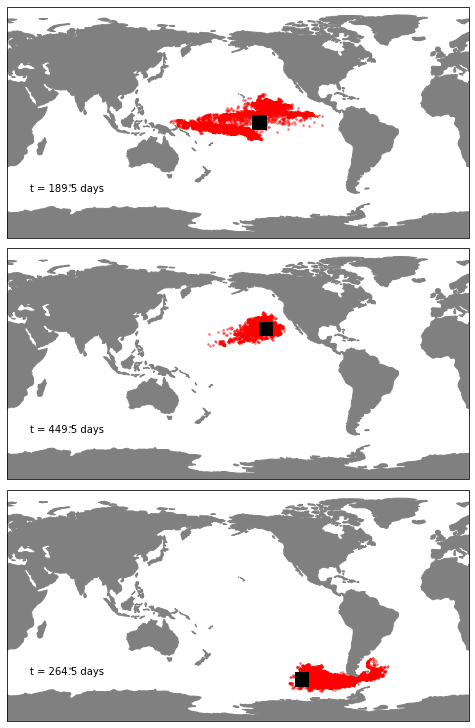

In [97]:
fig = plt.figure(figsize=(8,10),constrained_layout=True)
gs = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=-160))
ax1.set_global()
ax1.add_feature(cfeature.LAND, color='gray')
ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=-160))
ax2.set_global()
ax2.add_feature(cfeature.LAND, color='gray')
ax3 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=-160))
ax3.set_global()
ax3.add_feature(cfeature.LAND, color='gray')

axes = [ax1, ax2, ax3]

for i, ax in enumerate(axes):
    ax.scatter(dslist[i]['lon'][:,-1],dslist[i]['lat'][:,-1], c='r', s=3, alpha=0.4, transform=ccrs.PlateCarree())
    ax.scatter(dslist[i]['lon'][:,0],dslist[i]['lat'][:,0], c='k', s=3, alpha=0.4, transform=ccrs.PlateCarree())
    ax.text(0.05,0.2,'t = '+str((dslist[i]['time'][0,-1]-dslist[i]['time'][0,0]).values/ np.timedelta64(1, 'D'))+' days', transform=ax.transAxes)
    
plt.savefig(datadir+'advection')

## Side by side

In [109]:
region = 'NPSG'
dt = 60                       # [seconds]
outputdt = 12                 # [hours]
mixing = 'markov_0_'+biofouling
time_plot = round((runtime-91)*24/outputdt)
sizebinedges = [1e-3, 1e-4, 1e-5]
res ='1x1'
proc = ['bfnoadv','bfadv']
season = 'Oct'
season_string = {'Jan':'January - July', 'MAM':'March - September', 'JJA':'June - December', 'SON':'September - March','DJF':'December - June'}

In [110]:
ds_0 = xr.open_dataset(datadir+'regional_'+region+'_'+proc[0]+'_'+season+'_'+str(start_yr)+'_'+res+'res_'+mixing+'_'+str(rho_bf)+'rhobf_'+str(rho_pl)+'rhopl_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc')
ds_1 = xr.open_dataset(datadir+'regional_'+region+'_'+proc[1]+'_'+season+'_'+str(start_yr)+'_'+res+'res_'+mixing+'_'+str(rho_bf)+'rhobf_'+str(rho_pl)+'rhopl_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc')

In [111]:
dslist = [ds_0, ds_1]

In [112]:
mld_0 = np.mean(ds_0['mld'][:,1:],axis=0)
ez_0 = np.mean(ds_0['euphz'][:,1:],axis=0)
mld_0 = np.concatenate(([mld_0[0]],mld_0))
ez_0 = np.concatenate(([ez_0[0]],ez_0))

mld_1 = np.mean(ds_1['mld'][:,1:],axis=0)
ez_1 = np.mean(ds_1['euphz'][:,1:],axis=0)
mld_1 = np.concatenate(([mld_1[0]],mld_1))
ez_1 = np.concatenate(([ez_1[0]],ez_1))

In [113]:
mldlist = [mld_0, mld_1]
ezlist = [ez_0, ez_1]

In [116]:
obs_ids=[0,900]  # one year

In [117]:
split_ds_noadv = list(ds_0.groupby_bins('r_pl',sizebinedges[::-1]))[::-1]
split_ds_adv = list(ds_1.groupby_bins('r_pl',sizebinedges[::-1]))[::-1]
split_dslist = [split_ds_noadv, split_ds_adv]

In [118]:
depthbins = np.concatenate((np.linspace(0,445,90), np.linspace(450,5500,102)))
sub_depths = [[0,91],[90,len(depthbins)]]
starttimes=(ds_0['time'][0,obs_ids[0]:obs_ids[1]]-np.timedelta64(int(outputdt/2.), 'h')).values
endtime = (ds_0['time'][0,obs_ids[1]]+np.timedelta64(int(outputdt/2.), 'h')).values
timebins = np.append(starttimes,endtime)
daybins =(timebins-timebins[0]).astype(np.float64)*(np.timedelta64(1,'ns') / np.timedelta64(1,'D'))
timeperiod = obs_ids[1]-obs_ids[0]

In [119]:
depth_densities = np.zeros((len(dslist),len(split_ds_1),timeperiod,len(depthbins)-1))
depth_numbers = np.zeros((len(dslist),len(split_ds_1),timeperiod,len(depthbins)-1))

for k in range(len(dslist)):
    split_ds = split_dslist[k]
    for i in range(len(depth_densities[0])):
        for j in range(timeperiod):
            values, bins = np.histogram(split_ds[i][1]['z'].isel(obs=obs_ids[0]+j), depthbins)
            depth_numbers[k,i,j] = values/np.diff(depthbins)

In [120]:
depth_cmap = copy(plt.get_cmap('magma'))

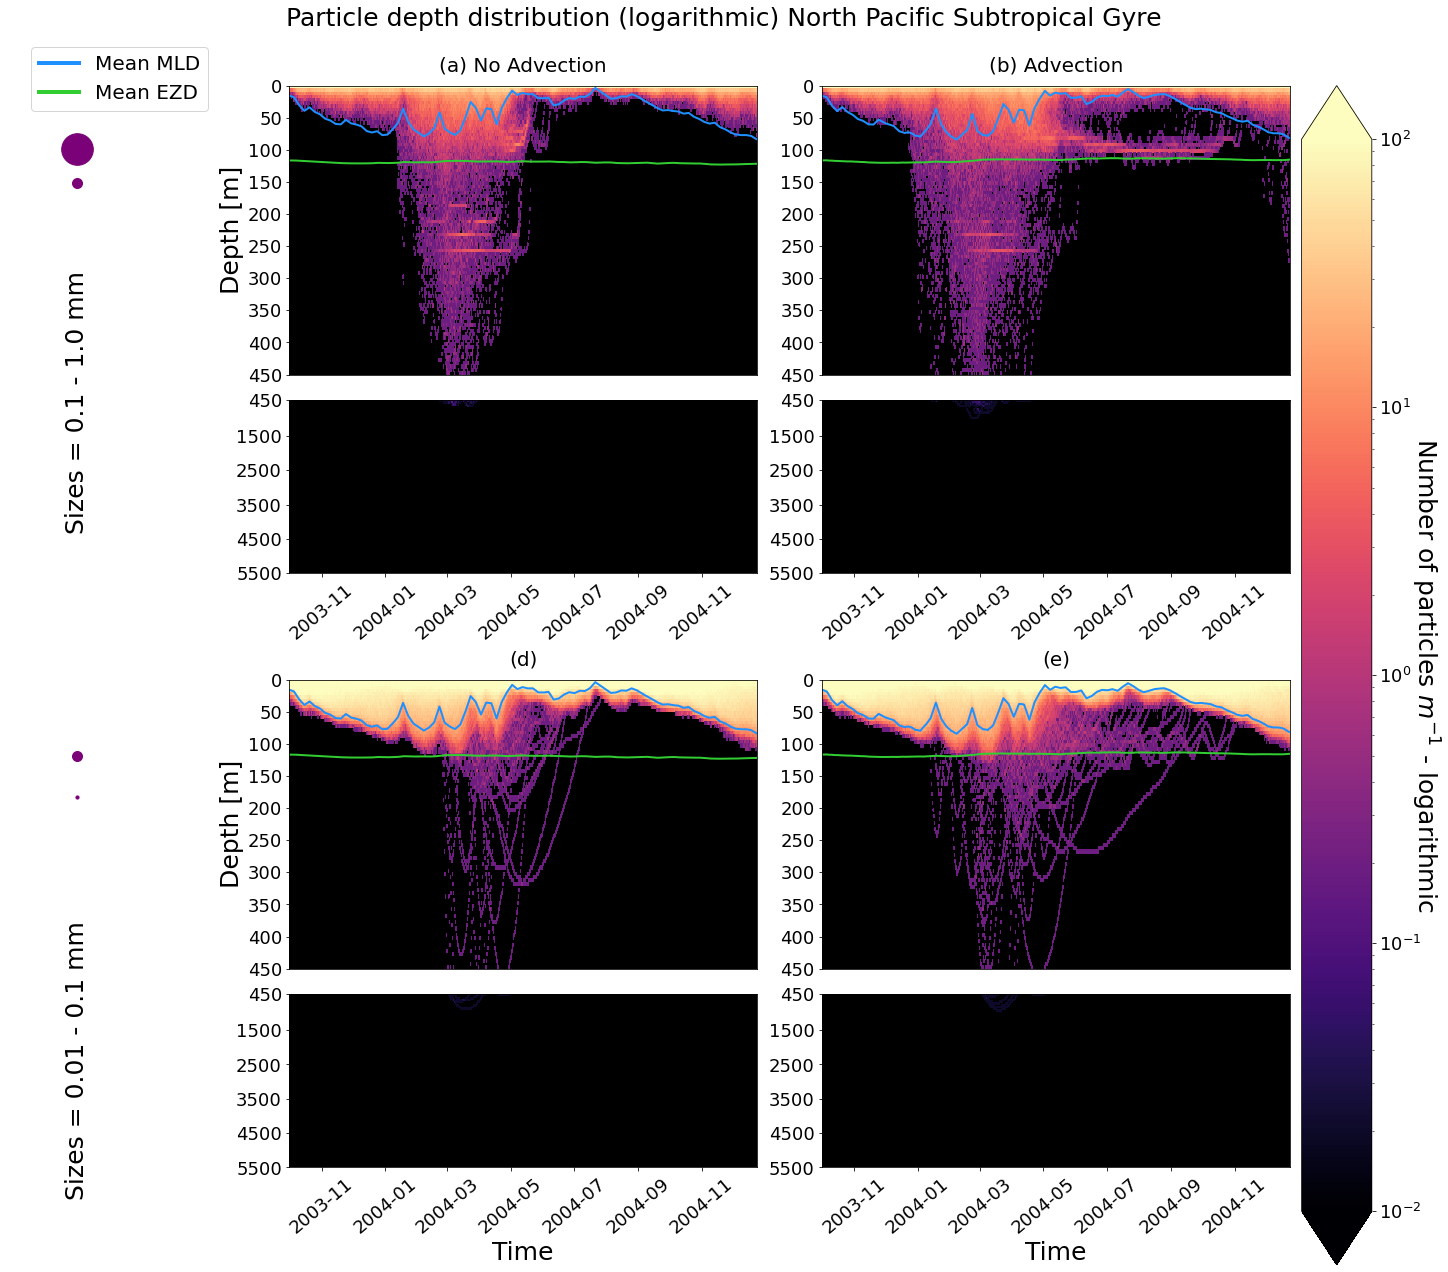

In [121]:
fig = plt.figure(figsize=(20,17),constrained_layout=True)
gs = gridspec.GridSpec(ncols=5, nrows=17, width_ratios=[0.3,1,1,1,0.15], figure=fig)
ax1 = fig.add_subplot(gs[:8, 0])
ax2 = fig.add_subplot(gs[8:, 0])

ax3 = fig.add_subplot(gs[:5, 1])
ax4 = fig.add_subplot(gs[5:8, 1]) 
ax5 = fig.add_subplot(gs[8:13, 1])
ax6 = fig.add_subplot(gs[13:16, 1])

ax7 = fig.add_subplot(gs[:5, 2])
ax8 = fig.add_subplot(gs[5:8, 2])
ax9 = fig.add_subplot(gs[8:13, 2])
ax10 = fig.add_subplot(gs[13:16, 2])

ax15 = fig.add_subplot(gs[:17, 4])
axes = [[ax1, ax2],[[ax3,ax4],[ax5,ax6]],[[ax7,ax8],[ax9,ax10]]]

for i, ax_r in enumerate(axes[1:]):   # column: region
    for c, ax_s in enumerate(ax_r):   # row: size
        for j, ax in enumerate(ax_s): # subfigure: depth
            ax.set_facecolor('k')
            ax.tick_params(axis='both', labelsize=18)#13
            pc = ax.pcolormesh(timebins,depthbins[sub_depths[j][0]:sub_depths[j][1]],depth_numbers[i,c,:,sub_depths[j][0]:sub_depths[j][1]-1].T, cmap=depth_cmap,norm=mcolors.LogNorm(vmin=1e-2, vmax=1e2))
            if j == 0:
                ax.plot(dslist[i]['time'][0,obs_ids[0]:obs_ids[1]], mldlist[i][obs_ids[0]:obs_ids[1]], linewidth=2, c='dodgerblue', label='Mean Mixed Layer Depth')
                ax.plot(dslist[i]['time'][0,obs_ids[0]:obs_ids[1]], ezlist[i][obs_ids[0]:obs_ids[1]], linewidth=2, c='limegreen', label='Mean Euphotic Depth')
                ax.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
                
                n=c*3+i
                ax.set_ylim(depthbins[sub_depths[j][1]-1], depthbins[sub_depths[j][0]])
                ax.set_yticks(np.arange(450,-10,-50))
#                 ax.set_yticks(np.concatenate((np.arange(depthbins[sub_depths[j][1]-1], depthbins[sub_depths[j][0]],-50),[depthbins[sub_depths[j][0]]])))
                if c == 0:
                    ax.set_title('('+chr(ord('a')+n)+') '+ adv[proc[i]], fontsize=20, y=1.03)
                else:
                    ax.set_title('('+chr(ord('a')+n)+')', fontsize=20, y=1.03)
                if i == 0:
                    ax.set_ylabel('Depth [m]', fontsize=25)#14
            if j == 1:
                ax.set_ylim(depthbins[sub_depths[j][1]-1], depthbins[sub_depths[j][0]])
                ax.set_yticks([5500,4500,3500,2500,1500,450])
#                 ax.set_yticks((np.arange(depthbins[sub_depths[j][1]-1], depthbins[sub_depths[j][0]],-1000)))
                ax.tick_params(axis='x', rotation=40) #20)
                if c == 1:
                    ax.set_xlabel('Time', fontsize=25) #14)
 
        
cb = fig.colorbar(pc, cax=ax15, extend='both')
cb.set_label('Number of particles $m^{-1}$ - logarithmic', size=25, rotation=270, labelpad=20)
cb.ax.tick_params(labelsize=18) #13)

fig.suptitle('Particle depth distribution (logarithmic) '+regions[region], fontsize=25, y=1.03) #20) #January 2004 - January 2005 
#plt.subplots_adjust(top=0.92)
#fig.tight_layout(h_pad=1)
#fig.tight_layout()
for k, ds_r in enumerate(split_ds_0):
    axes[0][k].scatter(0.5,0.87,s=sizebinedges[k]*1000000,color=r_pl_clist[0])
    axes[0][k].scatter(0.5,0.80,s=sizebinedges[k+1]*1000000,color=r_pl_clist[0])
    axes[0][k].set_ylim(0,1)
    axes[0][k].text(0.5,0.35,'Sizes = '+ str(ds_r[0].left*1000)+' - '+str(ds_r[0].right*1000)+' mm',rotation=90, fontsize=25, horizontalalignment='center',verticalalignment='center')
    axes[0][k].axis('off')
    
custom_lines = [Line2D([0], [0], color='dodgerblue', lw=4),
                Line2D([0], [0], color='limegreen', lw=4)]

ax1.legend(custom_lines, ["Mean MLD", "Mean EZD"], loc='upper right', fontsize=20, bbox_to_anchor=(1.5,1.1))
plt.savefig(datadir+'fig02_adv_'+region)

In [29]:
depth_Lobelle = np.zeros((len(dslist),len(split_ds_1),timeperiod,len(depthbins)-1))

In [30]:
for h in range(len(dslist)):
    print('h='+str(h))
    for k in range(len(split_ds_0)):
        for i in range(timeperiod):
            for j in range(len(depthbins)-1):
                trajs0 = np.logical_and(split_dslist[h][k][1]['z'][:,obs_ids[0]+i].values>depthbins[j],split_dslist[h][k][1]['z'][:,obs_ids[0]+i].values<depthbins[j+1])
                vs0 = split_dslist[h][k][1]['vs_init'][:,obs_ids[0]+i].values[trajs0]
                w_m0 = split_dslist[h][k][1]['w_m'][:,obs_ids[0]+i].values[trajs0]
                w_adv0 = split_dslist[h][k][1]['w_adv'][:,obs_ids[0]+i].values[trajs0]
                w_m_b0 = split_dslist[h][k][1]['w_m_b'][:,obs_ids[0]+i].values[trajs0]
                depth_Lobelle[h,k,i,j] = np.mean(np.divide(np.abs(vs0),np.abs(w_m0+w_adv0+w_m_b0)))

h=0


/Users/rfische1/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/rfische1/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rfische1/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


h=1


/Users/rfische1/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [31]:
Ratio_cmap = copy(plt.get_cmap('cmo.curl_r'))

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

Ratio_cmap = truncate_colormap(Ratio_cmap, 0.1, 0.9)

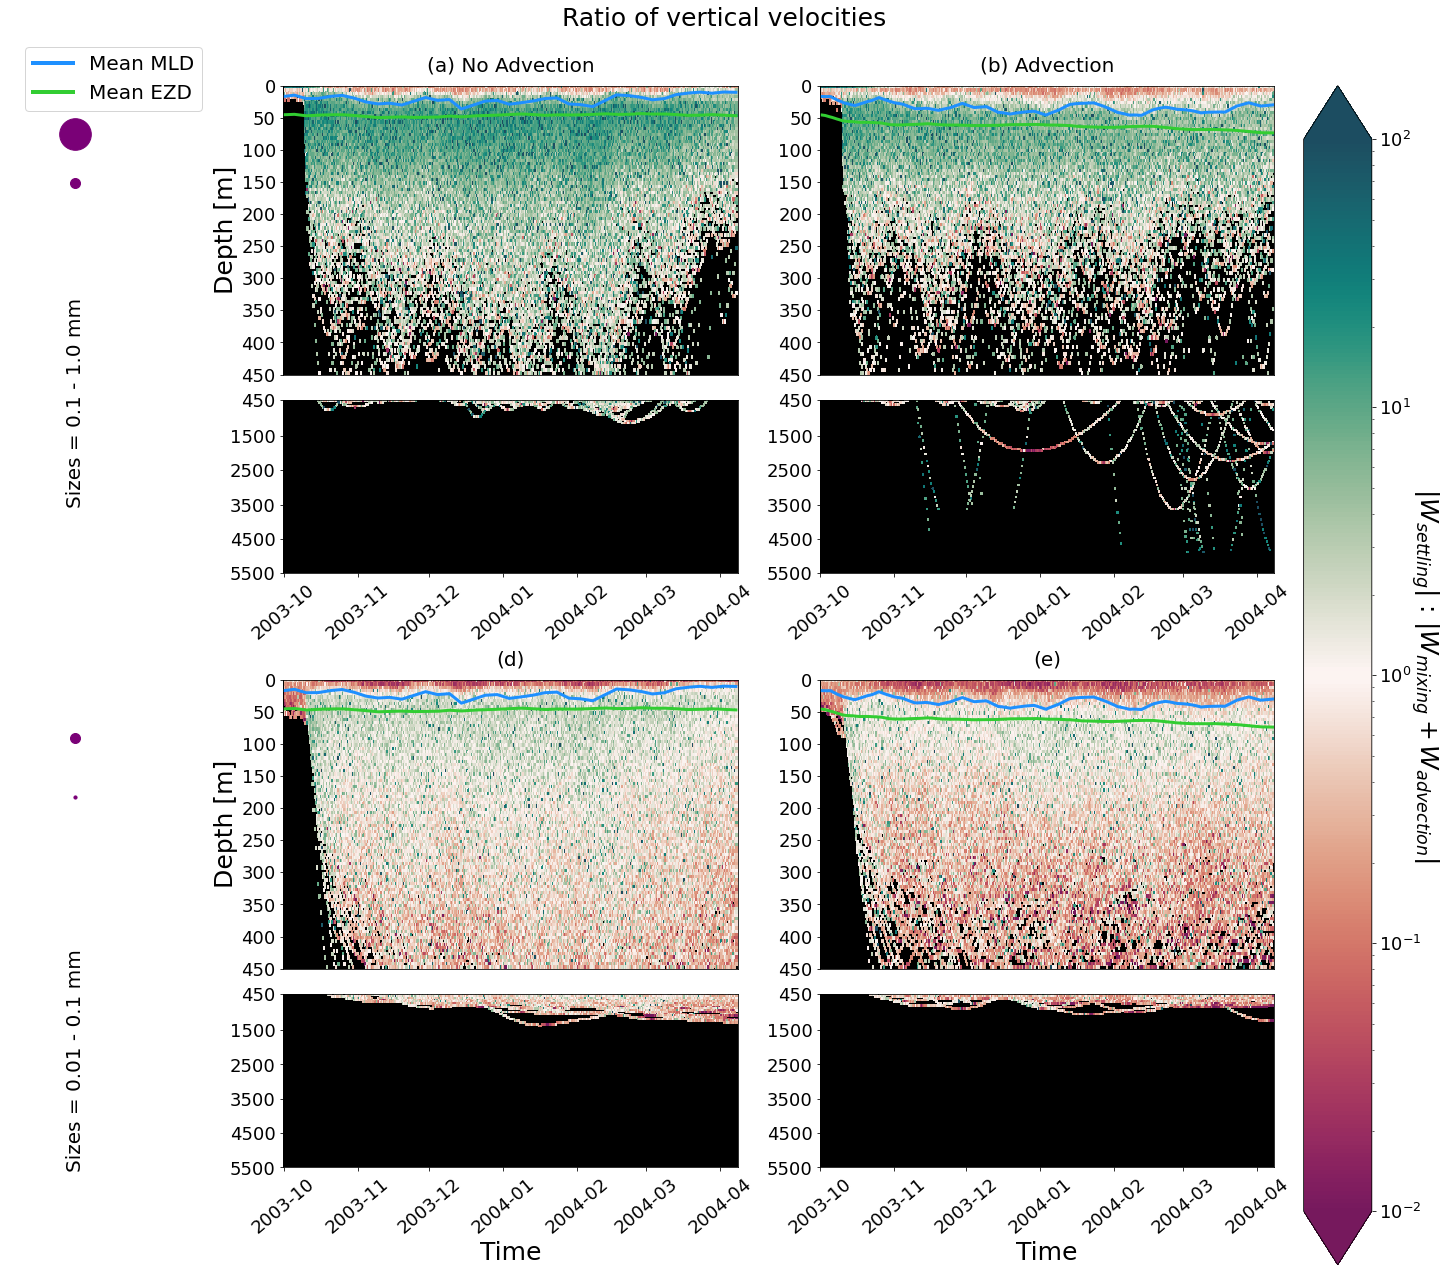

In [38]:
fig = plt.figure(figsize=(20,17),constrained_layout=True)
gs = gridspec.GridSpec(ncols=5, nrows=17, width_ratios=[0.3,1,1,1,0.15], figure=fig)
ax1 = fig.add_subplot(gs[:8, 0])
ax2 = fig.add_subplot(gs[8:, 0])

ax3 = fig.add_subplot(gs[:5, 1])
ax4 = fig.add_subplot(gs[5:8, 1]) 
ax5 = fig.add_subplot(gs[8:13, 1])
ax6 = fig.add_subplot(gs[13:16, 1])

ax7 = fig.add_subplot(gs[:5, 2])
ax8 = fig.add_subplot(gs[5:8, 2])
ax9 = fig.add_subplot(gs[8:13, 2])
ax10 = fig.add_subplot(gs[13:16, 2])

ax15 = fig.add_subplot(gs[:17, 4])
axes = [[ax1, ax2],[[ax3,ax4],[ax5,ax6]],[[ax7,ax8],[ax9,ax10]]]


for i, ax_r in enumerate(axes[1:]):
    for c, ax_s in enumerate(ax_r):
        for j, ax in enumerate(ax_s):
            ax.set_facecolor('k')
            pc = ax.pcolormesh(timebins,depthbins[sub_depths[j][0]:sub_depths[j][1]],depth_Lobelle[i,c,:,sub_depths[j][0]:sub_depths[j][1]-1].T, cmap=Ratio_cmap,norm=mcolors.LogNorm(vmin=1e-2, vmax=1e2))
            ax.tick_params(axis='both', labelsize=18)
            if j == 0:
                ax.plot(dslist[i]['time'][0,obs_ids[0]:obs_ids[1]], mldlist[i][obs_ids[0]:obs_ids[1]], linewidth=3, c='dodgerblue', label='Mean Mixed Layer Depth')
                ax.plot(dslist[i]['time'][0,obs_ids[0]:obs_ids[1]], ezlist[i][obs_ids[0]:obs_ids[1]], linewidth=3, c='limegreen', label='Mean Euphotic Depth')
                ax.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
                
                n=c*3+i
                ax.set_ylim(depthbins[sub_depths[j][1]-1], depthbins[sub_depths[j][0]])
                ax.set_yticks(np.arange(450,-10,-50))
                if c == 0:
                    ax.set_title('('+chr(ord('a')+n)+') '+ adv[proc[i]], fontsize=20, y=1.03)
                else:
                    ax.set_title('('+chr(ord('a')+n)+')', fontsize=20, y=1.03)
                if i == 0:
                    ax.set_ylabel('Depth [m]', fontsize=25)#14
            if j == 1:
                ax.set_ylim(depthbins[sub_depths[j][1]-1], depthbins[sub_depths[j][0]])
                ax.set_yticks([5500,4500,3500,2500,1500,450])
                ax.tick_params(axis='x', rotation=40) #20)
                if c == 1:
                    ax.set_xlabel('Time', fontsize=25) #14)
 
        
cb = fig.colorbar(pc, cax=ax15, extend='both')
cb.set_label('$|W_{settling}|$ : $|W_{mixing}+W_{advection}|$', size=25, rotation=270, labelpad=20)
cb.ax.tick_params(labelsize=18)

fig.suptitle('Ratio of vertical velocities', fontsize=25, y=1.03)

for k, ds_r in enumerate(split_ds_0):
    axes[0][k].scatter(0.5,0.90,s=sizebinedges[k]*1000000,color=r_pl_clist[0])
    axes[0][k].scatter(0.5,0.80,s=sizebinedges[k+1]*1000000,color=r_pl_clist[0])
    axes[0][k].set_ylim(0,1)
    axes[0][k].text(0.5,0.35,'Sizes = '+ str(ds_r[0].left*1000)+' - '+str(ds_r[0].right*1000)+' mm',rotation=90, fontsize=20, horizontalalignment='center',verticalalignment='center')
    axes[0][k].axis('off')
    
custom_lines = [Line2D([0], [0], color='dodgerblue', lw=4),
                Line2D([0], [0], color='limegreen', lw=4)]

ax1.legend(custom_lines, ["Mean MLD", "Mean EZD"], loc='upper right', fontsize=20, bbox_to_anchor=(1.5,1.1))
plt.savefig(datadir+'fig_04_adv')

In [34]:
depth_Dominant = np.ones((len(dslist),len(split_ds_1),timeperiod,len(depthbins)-1))*-1

In [35]:
for h in range(len(dslist)):
    print('h='+str(h))
    for k in range(len(split_ds_0)):
        for i in range(timeperiod):
            for j in range(len(depthbins)-1):
                trajs0 = np.logical_and(split_dslist[h][k][1]['z'][:,obs_ids[0]+i].values>depthbins[j],split_dslist[h][k][1]['z'][:,obs_ids[0]+i].values<depthbins[j+1])
                growth = split_dslist[h][k][1]['a_growth'][:,obs_ids[0]+i].values[trajs0]
                coll = split_dslist[h][k][1]['a_coll'][:,obs_ids[0]+i].values[trajs0]
                grazing = split_dslist[h][k][1]['a_gr'][:,obs_ids[0]+i].values[trajs0]
                lin = split_dslist[h][k][1]['a_l'][:,obs_ids[0]+i].values[trajs0]
                nonlin = split_dslist[h][k][1]['a_nl'][:,obs_ids[0]+i].values[trajs0]
                terms = np.array([np.mean(growth),np.mean(coll),np.mean(grazing),np.mean(lin),np.mean(nonlin)])
                if np.nanmax(terms)>0:
                    depth_Dominant[h,k,i,j] = np.argmax(terms)

h=0


/Users/rfische1/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rfische1/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/rfische1/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: All-NaN slice encountered
  del sys.path[0]


h=1


In [36]:
Dominant_clist = ['#ABEBC6','#BB8FCE', '#F5B7B1', '#FCF3CF', '#92acee'] 
Dominant_cmap = LinearSegmentedColormap.from_list('Dominant_cmap', Dominant_clist, N=5)
Dominant_cmap.set_under('k')

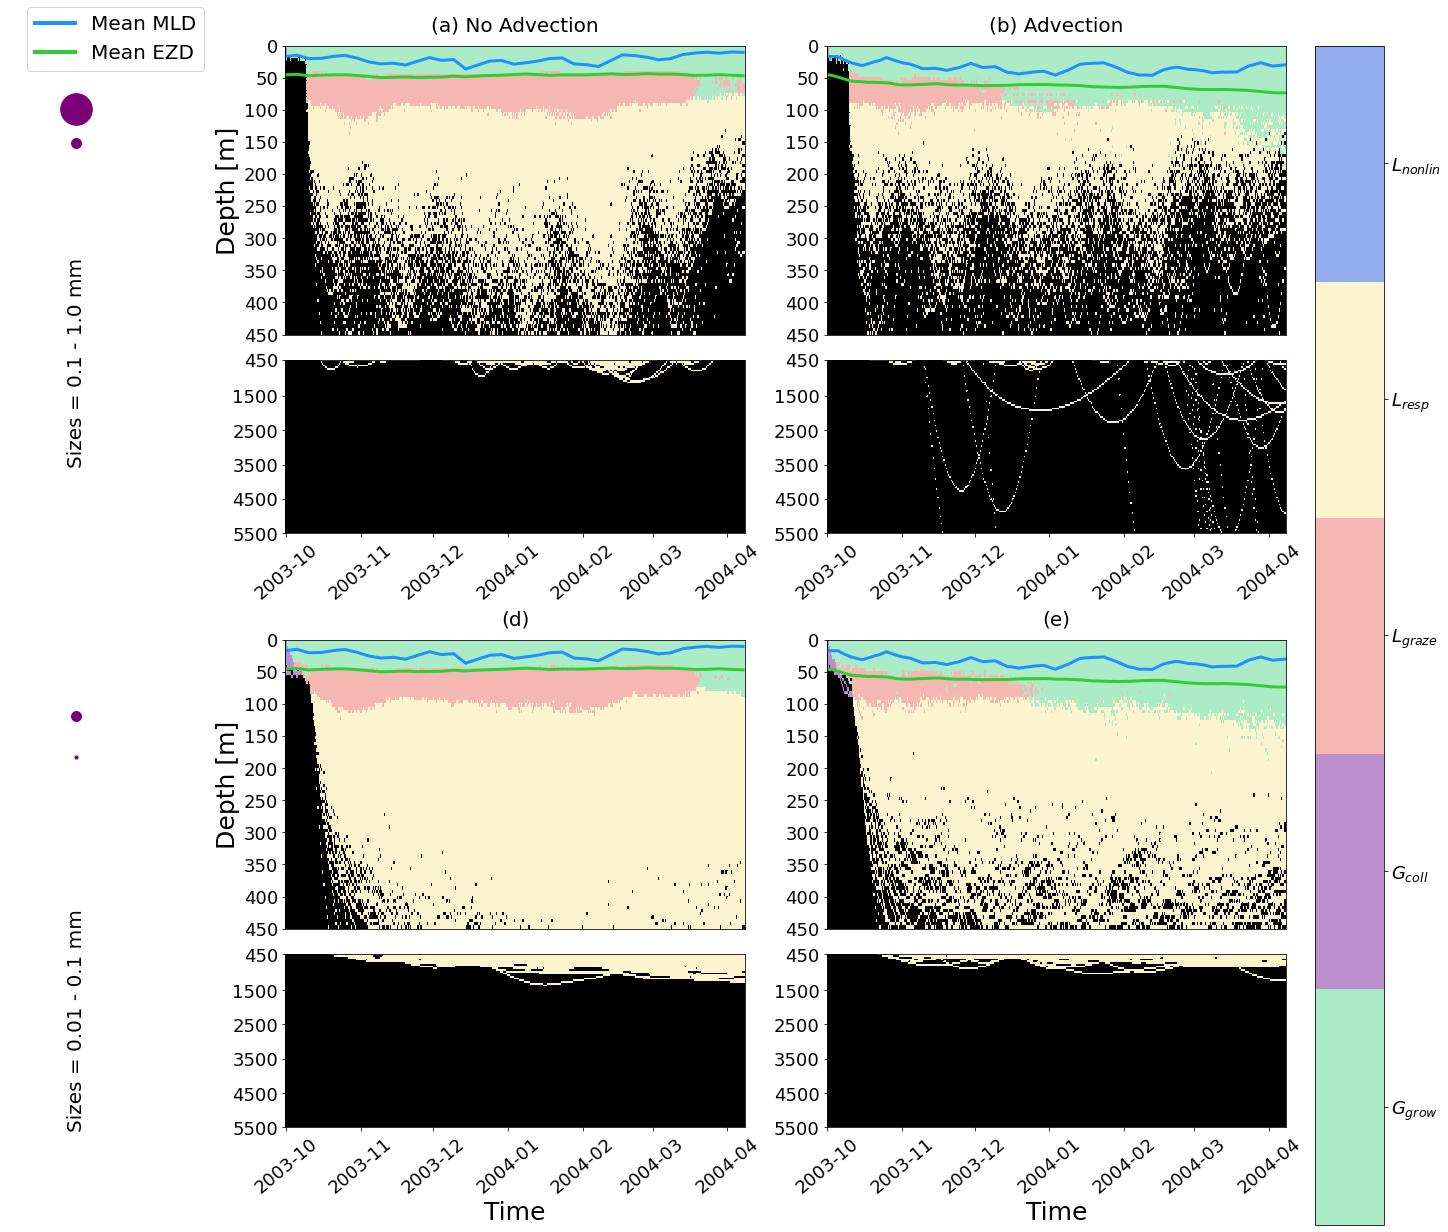

In [37]:
fig = plt.figure(figsize=(20,17),constrained_layout=True)
gs = gridspec.GridSpec(ncols=5, nrows=17, width_ratios=[0.3,1,1,1,0.15], figure=fig)
ax1 = fig.add_subplot(gs[:8, 0])
ax2 = fig.add_subplot(gs[8:, 0])

ax3 = fig.add_subplot(gs[:5, 1])
ax4 = fig.add_subplot(gs[5:8, 1]) 
ax5 = fig.add_subplot(gs[8:13, 1])
ax6 = fig.add_subplot(gs[13:16, 1])

ax7 = fig.add_subplot(gs[:5, 2])
ax8 = fig.add_subplot(gs[5:8, 2])
ax9 = fig.add_subplot(gs[8:13, 2])
ax10 = fig.add_subplot(gs[13:16, 2])

ax15 = fig.add_subplot(gs[:17, 4])
axes = [[ax1, ax2],[[ax3,ax4],[ax5,ax6]],[[ax7,ax8],[ax9,ax10]]]


for i, ax_r in enumerate(axes[1:]):
    for c, ax_s in enumerate(ax_r):
        for j, ax in enumerate(ax_s):
            ax.set_facecolor('k')
            pc = ax.pcolormesh(timebins,depthbins[sub_depths[j][0]:sub_depths[j][1]],depth_Dominant[i,c,:,sub_depths[j][0]:sub_depths[j][1]-1].T, cmap=Dominant_cmap,vmin=-0.5,vmax=4.5)#,norm=mcolors.LogNorm(vmin=1e-4, vmax=1e4))
            ax.tick_params(axis='both', labelsize=18)
            if j == 0:
                ax.plot(dslist[i]['time'][0,obs_ids[0]:obs_ids[1]], mldlist[i][obs_ids[0]:obs_ids[1]], linewidth=3, c='dodgerblue', label='Mean Mixed Layer Depth')
                ax.plot(dslist[i]['time'][0,obs_ids[0]:obs_ids[1]], ezlist[i][obs_ids[0]:obs_ids[1]], linewidth=3, c='limegreen', label='Mean Euphotic Depth')
                ax.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
                
                n=c*3+i
                ax.set_ylim(depthbins[sub_depths[j][1]-1], depthbins[sub_depths[j][0]])
                ax.set_yticks(np.arange(450,-10,-50))
                if c == 0:
                    ax.set_title('('+chr(ord('a')+n)+') '+ adv[proc[i]], fontsize=20, y=1.03)
                else:
                    ax.set_title('('+chr(ord('a')+n)+')', fontsize=20, y=1.03)
                if i == 0:
                    ax.set_ylabel('Depth [m]', fontsize=25)#14
            if j == 1:
                ax.set_ylim(depthbins[sub_depths[j][1]-1], depthbins[sub_depths[j][0]])
                ax.set_yticks([5500,4500,3500,2500,1500,450])
                ax.tick_params(axis='x', rotation=40) #20)
                if c == 1:
                    ax.set_xlabel('Time', fontsize=25) #14)
        
cb = fig.colorbar(pc, cax=ax15, ticks=[0,1,2,3,4])
# cb.set_label('$Growth$ - $Collisions$', size=15)
cb.ax.set_yticklabels(['$G_{grow}$','$G_{coll}$','$L_{graze}$','$L_{resp}$','$L_{nonlin}$'], size=25)
cb.ax.tick_params(labelsize=18)

for k, ds_r in enumerate(split_ds_0):
    axes[0][k].scatter(0.5,0.87,s=sizebinedges[k]*1000000,color=r_pl_clist[0])
    axes[0][k].scatter(0.5,0.80,s=sizebinedges[k+1]*1000000,color=r_pl_clist[0])
    axes[0][k].set_ylim(0,1)
    axes[0][k].text(0.5,0.35,'Sizes = '+ str(ds_r[0].left*1000)+' - '+str(ds_r[0].right*1000)+' mm',rotation=90, fontsize=20, horizontalalignment='center',verticalalignment='center')
    axes[0][k].axis('off')
    
custom_lines = [Line2D([0], [0], color='dodgerblue', lw=4),
                Line2D([0], [0], color='limegreen', lw=4)]

ax1.legend(custom_lines, ["Mean MLD", "Mean EZD"], loc='upper right', fontsize=20, bbox_to_anchor=(1.5,1.1))
plt.savefig(datadir+'fig_05_adv')